# Домашнее задание: Семинар 1
## Сухов Артем Сергеевич

## Вариант 1
**Цель**: контроль дисперсии весов.

*   Разработайте архитектуру, которая будет за 5 слоев приводить тензор к
размерности (1, 512, 1, 1).

*   Условие: дисперсия весов третьего слоя должна быть в два раза больше, чем у второго и четвертого.

*   Эксперимент: Проверьте влияние увеличенной дисперсии третьего слоя на распределение активаций после GAP и визуализируйте их гистограмму.

Импортируем нужные библиотеки

In [161]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Рандомный тензор $x$

In [162]:
x = torch.randn(1, 3, 32, 32)

Модель с контролем дисперсий (согласно условиям задания)

In [163]:
class NetV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1, bias=False)
        self.conv5 = nn.Conv2d(512, 512, 1, bias=False)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.relu = nn.ReLU()

        # дисперсия весов 3 слоя должна быть в два раза больше, чем у 2 и 4.
        nn.init.normal_(self.conv1.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.conv2.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.conv3.weight, mean=0.0, std=0.04)
        nn.init.normal_(self.conv4.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.conv5.weight, mean=0.0, std=0.01)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.conv5(x)
        x_gap = self.gap(x)

        return x_gap

Базовая модель (дисперсия везде одинаковая)

In [164]:
class NetBase(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1, bias=False)
        self.conv5 = nn.Conv2d(512, 512, 1, bias=False)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.relu = nn.ReLU()

        for m in [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5]:
            nn.init.normal_(m.weight, mean=0.0, std=0.02)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.conv5(x)
        x_gap = self.gap(x)

        return x_gap

Эксперимент с двумя сетками

In [165]:
model_v1 = NetV1()
model_base = NetBase()

out_v1 = model_v1(x)
out_base = model_base(x)

print(out_v1.shape)
print(out_base.shape)

torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])


In [166]:
def print_weight_stats(model, name):
    print(f"\n{name}")
    for i, layer in enumerate([model.conv1, model.conv2, model.conv3, model.conv4, model.conv5]):
        w = layer.weight.data
        print(f"conv{i+1}: mean={w.mean().item():.5f}, var={w.var().item():.5f}")

print_weight_stats(model_v1, "Неравные дисперсии")
print_weight_stats(model_base, "Одинаковые дисперсии")


Неравные дисперсии
conv1: mean=0.00039, var=0.00010
conv2: mean=-0.00006, var=0.00040
conv3: mean=0.00008, var=0.00161
conv4: mean=0.00004, var=0.00040
conv5: mean=-0.00000, var=0.00010

Одинаковые дисперсии
conv1: mean=0.00073, var=0.00040
conv2: mean=0.00001, var=0.00040
conv3: mean=0.00008, var=0.00040
conv4: mean=0.00001, var=0.00040
conv5: mean=-0.00005, var=0.00040


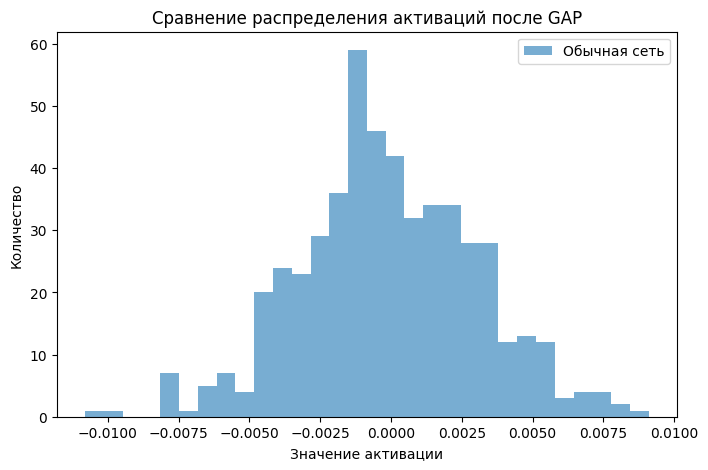

In [172]:
plt.figure(figsize=(8,5))
plt.hist(out_base.detach().numpy().flatten(), bins=30, alpha=0.6, label='Обычная сеть')
plt.hist(out_v1.detach().numpy().flatten(), bins=30, alpha=0.6, label='С увеличенной дисперсией (3-й слой)')
plt.legend()
plt.title("Сравнение распределения активаций после GAP")
plt.xlabel("Значение активации")
plt.ylabel("Количество")
plt.show()

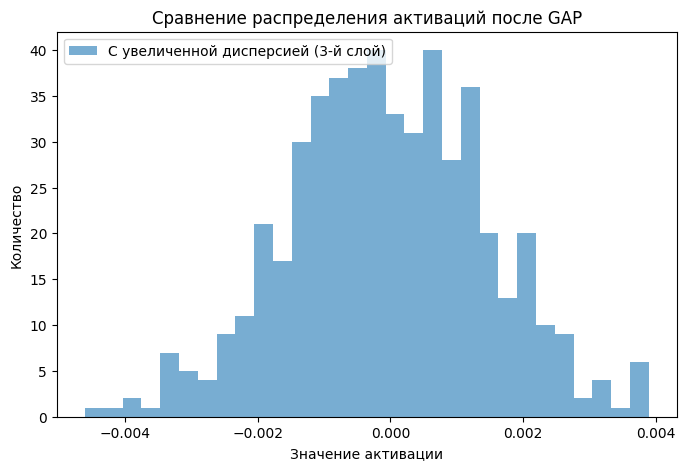

In [171]:
plt.figure(figsize=(8,5))
plt.hist(out_v1.detach().numpy().flatten(), bins=30, alpha=0.6, label='С увеличенной дисперсией (3-й слой)')
plt.legend()
plt.title("Сравнение распределения активаций после GAP")
plt.xlabel("Значение активации")
plt.ylabel("Количество")
plt.show()

В эксперименте оказалось, что при увеличении дисперсии весов третьего слоя сами активации после GAP стали более сжатыми (на графике).

Это можно наверно обьяснить тем, что при большом разбросе весов значения на промежуточных слоях сильнее отклоняются и часть из них гасится ReLU.

## Вариант 2
**Цель**: Контроль пространственных размерностей через свертки и пулинг.

*   Спроектируйте сеть для выхода (64, 16, 16) за не более 3 слоев свертки.
*   словие: Используйте как минимум один слой с padding=0, чтобы часть пространственной информации была потеряна. Можно менять в таких условиях kernel_size и stride.
*   Эксперимент: Сравните выход с использованием padding=0 и padding=1, оцените разницу в размерности и среднее значение активаций.

In [168]:
class NetPad(nn.Module):
    def __init__(self, padding=0):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=2+padding, stride=2, padding=padding) # 32->16
        self.act1  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # 16->16
        self.act2  = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        return x

In [169]:
x = torch.randn(1, 3, 32, 32)

model_pad0 = NetPad(padding=0)
model_pad1 = NetPad(padding=1)

with torch.no_grad():
    y0 = model_pad0(x)
    y1 = model_pad1(x)

with torch.no_grad():
    out_pad0 = model_pad0(x)
    out_pad1 = model_pad1(x)

print("Padding=0: shape =", out_pad0.shape, ", mean activation =", out_pad0.mean().item())
print("Padding=1: shape =", out_pad1.shape, ", mean activation =", out_pad1.mean().item())

Padding=0: shape = torch.Size([1, 64, 16, 16]) , mean activation = 0.09776302427053452
Padding=1: shape = torch.Size([1, 64, 16, 16]) , mean activation = 0.09578391909599304


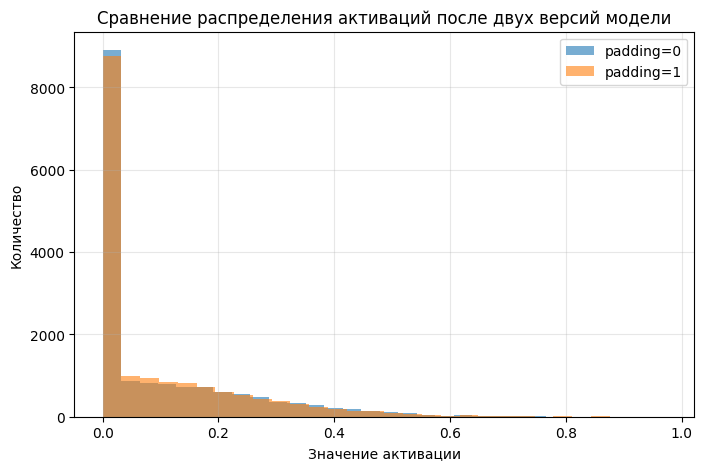

In [170]:
plt.figure(figsize=(8,5))
plt.hist(out_pad0.detach().numpy().flatten(), bins=30, alpha=0.6, label='padding=0')
plt.hist(out_pad1.detach().numpy().flatten(), bins=30, alpha=0.6, label='padding=1')
plt.title("Сравнение распределения активаций после двух версий модели")
plt.xlabel("Значение активации")
plt.ylabel("Количество")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

При padding=0 часть информации на границах теряется, но среднее значение активаций чуть выше. Соответсвенно наоборот - при padding=1 границы дополняются нулями, распределение активаций чуть «сжато», среднее значение ниже.